## Fast AI example

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,?,Bachelors,Married-civ-spouse,?,Husband,White,False,55.000000,136818.998613,13.0,<50k
1,Private,10th,Married-civ-spouse,Machine-op-inspct,Husband,Black,False,62.000000,224953.000598,6.0,<50k
2,State-gov,Bachelors,Married-civ-spouse,Protective-serv,Husband,White,False,32.000000,400132.002435,13.0,>=50k
3,Self-emp-not-inc,10th,Never-married,Other-service,Own-child,White,False,16.999999,228785.999385,6.0,<50k
4,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,Black,False,53.000001,268544.998005,9.0,<50k
5,Local-gov,Bachelors,Married-civ-spouse,Prof-specialty,Wife,White,False,39.000000,119420.998930,13.0,<50k
6,Self-emp-inc,Prof-school,Married-civ-spouse,Prof-specialty,Husband,White,False,50.000000,158293.999645,15.0,>=50k
7,Private,9th,Married-civ-spouse,Craft-repair,Husband,White,False,55.000000,178644.000197,5.0,<50k
8,Private,Prof-school,Married-civ-spouse,Prof-specialty,Husband,White,False,37.000000,167415.000058,15.0,>=50k
9,Self-emp-inc,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,False,59.999999,160061.998604,9.0,<50k


epoch,train_loss,valid_loss,accuracy,time
0,0.370753,0.347219,0.833999,00:02
1,0.367080,0.346554,0.839681,00:02
2,0.359966,0.346529,0.839527,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.505628,0.416108,0.792537,00:00
1,0.413481,0.346538,0.838913,00:00
2,0.382661,0.342499,0.840295,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.752558,0.626529,0.766892,00:00
1,0.628197,0.466041,0.822021,00:00
2,0.553260,0.413550,0.811271,00:00


              precision    recall  f1-score   support

        <50k       0.81      0.98      0.89      4994
       >=50k       0.79      0.26      0.39      1518

    accuracy                           0.81      6512
   macro avg       0.80      0.62      0.64      6512
weighted avg       0.81      0.81      0.77      6512



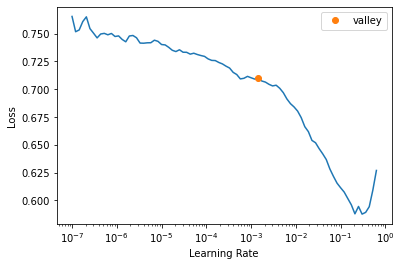

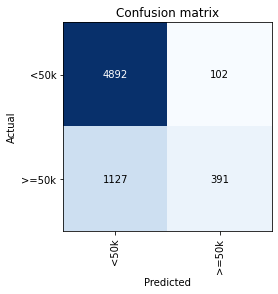

In [1]:
# https://walkwithfastai.com/tab.clas.binary
from fastai.tabular.all import *

path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
cat = Categorify()
to = TabularPandas(df, cat, cat_names)
cats = to.procs.categorify
norm = Normalize()
to = TabularPandas(df, norm, cont_names=cont_names)
norms = to.procs.normalize

fm = FillMissing(fill_strategy=FillStrategy.median)
to = TabularPandas(df, fm, cont_names=cont_names)
splits = RandomSplitter()(range_of(df))

range_of(df)[:5], len(df)
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
y_names = 'salary'
y_block = CategoryBlock()
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=y_names, y_block=y_block, splits=splits)
dls = to.dataloaders()
trn_dl = TabDataLoader(to.train, bs=64, shuffle=True, drop_last=True)
val_dl = TabDataLoader(to.valid, bs=128)
dls = DataLoaders(trn_dl, val_dl)
dls.show_batch()
emb_szs = get_emb_sz(to); emb_szs
to['workclass'].nunique()
cont_len = len(to.cont_names); cont_len
batch = dls.one_batch(); len(batch)
net = TabularModel(emb_szs, cont_len, 2, [200,100])
learn = tabular_learner(dls, [200,100], metrics=accuracy)
learn.lr_find()
learn.fit(3, 1e-2)
dls = to.dataloaders(bs=1024)
learn = tabular_learner(dls, [200,100], metrics=accuracy)
learn.fit(3, 1e-2)
dls = to.dataloaders(bs=4096)
learn = tabular_learner(dls, [200,100], metrics=accuracy)
learn.fit(3, 1e-2)
row, cls, probs = learn.predict(df.iloc[0])
dl = learn.dls.test_dl(df.iloc[:100])

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.print_classification_report()

# NOW OURS:


Learning Rate:  SuggestedLRs(valley=0.0006918309954926372)


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,time
0,1.475019,1.404705,0.173179,0.253611,0.518199,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,time
0,1.380991,1.410324,0.183837,0.320349,0.609287,00:00
1,1.348522,1.391197,0.234458,0.367567,0.654507,00:00
2,1.326620,1.372979,0.281972,0.389898,0.660840,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,time
0,1.288625,1.310498,0.396536,0.451669,0.670760,00:00
1,1.269941,1.247031,0.416963,0.436050,0.666944,00:00
2,1.249914,1.237046,0.430728,0.435708,0.663404,00:00


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,time
0,1.204176,1.224266,0.437389,0.445369,0.661874,00:00
1,1.190488,1.192802,0.443162,0.407091,0.649683,00:00
2,1.172163,1.163129,0.459147,0.433630,0.666560,00:00
3,1.155401,1.166846,0.460036,0.435091,0.661333,00:00


Better model found at epoch 0 with balanced_accuracy_score value: 0.4453686358298734.
No improvement since epoch 0: early stopping


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,time
0,1.184726,1.208900,0.440497,0.441034,0.671341,00:00
1,1.177583,1.183039,0.456039,0.440292,0.664185,00:00
2,1.162657,1.174128,0.444050,0.409132,0.656541,00:00
3,1.147766,1.169468,0.451599,0.400711,0.660782,00:00
4,1.136578,1.176207,0.448934,0.421959,0.661751,00:00
5,1.127185,1.163456,0.446270,0.406373,0.659261,00:00
6,1.117469,1.153846,0.466252,0.441815,0.674178,00:00
7,1.108827,1.148318,0.460480,0.426249,0.676488,00:00
8,1.100675,1.150397,0.455151,0.414688,0.671627,00:00
9,1.093602,1.149249,0.451155,0.409061,0.671052,00:00


Better model found at epoch 0 with train_loss value: 1.1847256422042847.
Better model found at epoch 2 with train_loss value: 1.1626572608947754.
Better model found at epoch 3 with train_loss value: 1.1477664709091187.
Better model found at epoch 4 with train_loss value: 1.1365776062011719.
Better model found at epoch 6 with train_loss value: 1.1174688339233398.
Better model found at epoch 8 with train_loss value: 1.1006746292114258.


              precision    recall  f1-score   support

           1       0.65      0.58      0.61       236
           2       0.37      0.20      0.26       656
           3       0.24      0.08      0.12       460
           4       0.47      0.80      0.59       900

    accuracy                           0.46      2252
   macro avg       0.43      0.41      0.40      2252
weighted avg       0.41      0.46      0.40      2252



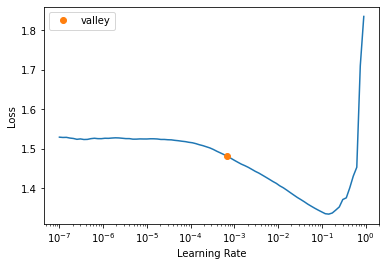

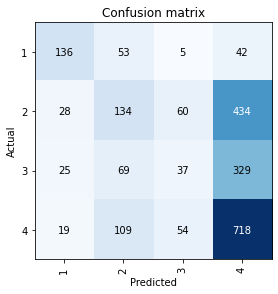

In [34]:
# https://walkwithfastai.com/tab.clas.binary
from fastai.tabular.all import *

DS = '/home/javier/mis_proyectos/calculos_Fer/DATAJAVI_V5_deuce.csv'

### FASTAI:
df = pd.read_csv(DS)

cat_names = ['DIRECCIÓN:1 abierto;2 al cuerpo;3 a la T']
cont_names = ['V(km/h)', '[YA]', 'ZA', 'Znet', 'TIME', 'difV', '&(grados)', 'ANG. IN', 'dLinea']
y_names = ['Efectividad']

cat = Categorify()
to = TabularPandas(df, cat, cat_names)
cats = to.procs.categorify
norm = Normalize()

splits = RandomSplitter(valid_pct=0.3)(range_of(df))
procs = [Categorify, FillMissing, Normalize]

procs = [Categorify, FillMissing, Normalize]
y_names = 'Efectividad'
y_block = CategoryBlock()
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=y_names, y_block=y_block, splits=splits)

dls = to.dataloaders(bs=1024)
# learn = tabular_learner(dls, [256, 128, 128, 64], loss_func=FocalLossFlat(), metrics=[accuracy]) # loss_func=CrossEntropyLossFlat(),  256, 128, 128, 64
learn = tabular_learner(dls, [200,100], metrics=[accuracy, BalancedAccuracy(), RocAuc()]) # loss_func=CrossEntropyLossFlat(),  256, 128, 128, 64


lr = learn.lr_find()
print("\nLearning Rate: ", lr)

###
# lr = 9e-3
lr = lr[0]
learn.fit_one_cycle(1, slice(lr/(2.6**4),lr))#, moms=(0.8,0.7))
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(lr/(2.6**4),lr))
learn.unfreeze()
lr = lr*5 # 4e-2
learn.fit_one_cycle(3, slice(lr/(2.6**4),lr))

keep_path = learn.path
learn.path = Path('/home/javier/mis_proyectos/')

# set the model path to a writeable directory. If you don't do this, the code will produce an error on Gradient
# learn.path = Path(model_path)
learn.fit_one_cycle(5, slice(1e-4, 8e-3), 
                    cbs=[EarlyStoppingCallback(monitor='balanced_accuracy_score', min_delta=0.0001, patience=3),
                    SaveModelCallback(monitor='balanced_accuracy_score', min_delta=0.01)])

learn.fit_one_cycle(10, slice(8e-4, 8e-3),
                    cbs=[EarlyStoppingCallback(monitor='train_loss', min_delta=0.001, patience=3),
                    SaveModelCallback(monitor='train_loss', min_delta=0.01)])
# learn.fit_one_cycle(12, slice(5e-4, 5e-3))

### reset the model path
learn.path = keep_path

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.print_classification_report()

In [263]:
learn.validate()

(#4) [1.1885197162628174,0.45825931429862976,0.43913720614058316,0.6720887137371739]

In [246]:
learn.validate()

(#4) [1.1721267700195312,0.45603907108306885,0.4312660847304324,0.6686731035311079]